In [50]:
import torch
from dlc_practical_prologue import generate_pair_sets
import torch.nn as nn
from print_util import *
import matplotlib.pyplot as plt

## 1. Generate raw data, process it

In [2]:
train_input_0, train_target_0, train_classes_0, test_input_0, test_target_0, test_classes_0 = generate_pair_sets(1000)

In [3]:
def normalize_data(tensor):
    mu, std = tensor.mean(), tensor.std()
    tmp = tensor.sub(mu).div(std)
    return tmp

In [4]:
def convert_to_one_hot_labels(target):
    tmp = target.new_zeros(target.size(0), target.max() + 1)
    tmp.scatter_(1, target.view(-1, 1), 1.0)
    return tmp

_We normalized the data so it has mean 0 and std 1._

In [5]:
train_input = normalize_data(train_input_0)
# train_target = convert_to_one_hot_labels(train_target_0)
train_target = train_target_0

test_input = normalize_data(test_input_0)
# test_target = convert_to_one_hot_labels(test_target_0)
test_target = test_target_0

In [6]:
print("Training set mean = {a}".format(a = train_input.mean().item()))
print("Training set std = {s}\n".format(s = train_input.std().item()))
print("Test set mean = {a}".format(a = test_input.mean().item()))
print("Test set std = {s}".format(s = test_input.std().item()))

Training set mean = -4.7528015301168125e-08
Training set std = 1.0

Test set mean = 5.0797755335452166e-08
Test set std = 0.9999999403953552


## 2. Creating & Training models

In [7]:
import models
import torch.nn.functional as F

In [52]:
basic_model = models.BaselineNetwork()

In [53]:
def test(test_input, test_target, test_classes, model, criterion, batch_size):
    
    with torch.no_grad():
        nb_data_errors = 0
        loss_sum = 0
        
        for inputs, targets in zip(test_input.split(batch_size),
                                  test_target.split(batch_size)):
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss_sum += loss
            _, predicted_classes = torch.max(outputs, 1)
            
            for k in range(len(inputs)):
                if targets[k] != predicted_classes[k]:
                    nb_data_errors = nb_data_errors + 1

        accuracy = (1 - (nb_data_errors / test_input.size(0))) * 100
        
        return accuracy, loss_sum.item()

In [54]:
#def log_acc(epoch, max_epoch, test_acc, train_acc):
#    print('[' + repr(epoch) + '/' + repr(max_epoch) + ']'.ljust(20) + repr(train_acc).ljust(20) + repr(test_acc).ljust(20))

In [55]:
def train_model(model, train_input, train_target, train_classes, test_input, test_target, test_classes, nb_epoch, batch_size, optimizer_params):
    nb_epoch, batch_size = nb_epoch, batch_size
    lr, momentum = optimizer_params['lr'], optimizer_params['momentum']
    
    optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = momentum)
    criterion = nn.CrossEntropyLoss()
    log_acc_loss_header(color=Color.GREEN)
    
    train_accuracies = []
    train_losses = []
    test_accuracies = []
    test_losses = []
    
    for e in range(nb_epoch):
        for inputs, targets in zip(train_input.split(batch_size),
                                  train_target.split(batch_size)):
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_acc, train_loss = test(train_input, train_target, train_classes, model, criterion, batch_size)
        test_acc, test_loss = test(test_input, test_target, test_classes, model, criterion, batch_size)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        log_acc_loss(e, nb_epoch, 0, train_loss, train_acc, test_loss, test_acc, persistent=False)
    print()
    return train_accuracies, train_losses, test_accuracies, test_losses

In [56]:
train_accuracies, train_losses, test_accuracies, test_losses = train_model(basic_model, train_input, train_target, train_classes_0, test_input, test_target, test_classes_0, 10, 32, {'lr': 0.01, 'momentum':0.9})

Epoch       Time    Train loss     Train accuracy      Test loss      Test accuracy       
[10/10]     0s      1.0871         99.1000             22.8117        78.9000             


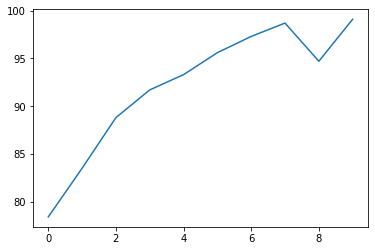

In [57]:
plt.plot(train_accuracies)

In [13]:
BATCH_SIZE = 10
LOG_INTERVAL = 20

In [15]:
test(test_input, test_target, test_classes_0, basic_model, nn.CrossEntropyLoss(), 32)

(81.0, 31.63132667541504)

In [ ]:
learning_rates = [0.001, 0.01] #, 0.1]
momentums = [0.9] #[0.5, 0.7, 0.9]
nb_epochs = [20, 50] #, 100]
batch_sizes = [16, 32] #, 64]

best_accuracy = 0
best_params = {}

for lr in learning_rates:
    for momentum in momentums:
        for nb_epoch in nb_epochs:
            for batch_size in batch_sizes:
                optimizer_params = {'lr':lr, 'momentum':momentum}
                
                model = models.BaselineNetwork()
                
                train_model(model, train_input, train_target, train_classes_0, nb_epoch, batch_size, optimizer_params)
                
                accuracy = test(test_input, test_target, test_classes_0, model, nn.CrossEntropyLoss())
                
                print(lr)
                print(momentum)
                print(nb_epoch)
                print(batch_size)
                print("\n")
                
                
                
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params['lr'] = lr
                    best_params['momentum'] = momentum
                    best_params['nb_epoch'] = nb_epoch
                    best_params['batch_size'] = batch_size
                    
print("Best accuracy obtained = {a}\n".format(a = best_accuracy))
print("with the following hyperparameters:\n")
print(best_params)

## 3. Testing model

_In order to test the model we will generate new data (training and test set), retrained the model on the new data en evaluate it on the new test set. We will do this process more than 10 times and estimates the mean accuracy as well as its standard deviation._

In [ ]:
nb_rounds = 10
test_model = models.BaselineNetwork

In [ ]:
def evaluate_model(model, nb_rounds, criterion):
    
    accuracies = []
    
    for round in range(nb_rounds):
        
        # initialize new model
        model_evaluated = model()
        # generate new data
        train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(1000)
        train_input = normalize_data(train_input)
        test_input = normalize_data(test_input)
        
        train_model(model_evaluated, train_input, train_target, train_classes, 50, 16, {'lr': 0.01, 'momentum': 0.9})
        
        accuracy = test(test_input, test_target, test_classes, model_evaluated, criterion)
        
        print("Round {i}: accuracy = {a}".format(i = (round + 1), a = accuracy))
        
        accuracies.append(accuracy)
        
    return torch.FloatTensor(accuracies)

In [ ]:
accuracies = evaluate_model(test_model, nb_rounds, nn.CrossEntropyLoss())

In [ ]:
print("The mean accuracy is: {a}".format(a = accuracies.mean()))
print("The accuracy std is: {s}".format(s = accuracies.std()))